# Water Distribution Dataset

This notebook implements the generation of the custom dataset used in the experiments.

## Dataset specification

The dataset consists of artificially generated graphs, where nodes represent distribution points and edges represent pipes. Each node has a set of features, being a 1-hot encoding of the strength of the source of water at that point. We assume that source of water $v$ distributes water to all points located in a radius of $k_v$, where $k_v$ is the strength of source $v$.

The targets are binary labels, where a label of 1 means that the node is a tap, and a label of 0 means that the node is not a tap (no water is distributed to that point).

## Dataset generation

To cover a wider spectrum of experiments, we generate several datasets, changing the main specification parameters:
- $k_{max}$ - the maximum value of $k_v$ for all sources
- ${\rho}_{source}$ - the probability distribution of a node being a source of a given strength

For each such dataset, we generate $1000$ graphs. The graphs are taken from the PATTERN dataset, and the features are generated randomly, according to the pre-defined probability distribution. The labels are then generated according to the specification.

In [1]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset, FakeDataset
from torch_geometric.data import DataLoader, Data, Batch, Dataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

import pdb

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [2]:
from datasets.wddataset.wddataset import WDDataset

## Visualisation

In [3]:
# @title [RUN] Helper functions for plots and visualisations

####### VISUALISATIONS #######

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)
      
        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery 
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def hash_node_embedings(node_emb):
  """ Hash the tensor representing nodes' features 
  to a number in [0,1] used to represent a color

  Args:
    node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
  Returns:
    list of num_graphs arrays in [0,1], each of dim (num_nodes) 
  """
  chunk_size_graph = [x.shape[0] for x in node_emb]
  start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]
  hash_kernel = np.random.randn(node_emb[0].shape[1])
  node_emb_flatten = np.array([x.dot(hash_kernel) for x in node_emb]).flatten()
  min_emb = node_emb_flatten.min()
  max_emb = node_emb_flatten.max()
  node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb+1e-8)


  #split in graphs again according to (start_idx_graph, chunk_size_graph)
  node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
  return node_emb_hashed


def visualize_graph(graph):
    print(graph)
    gallery([graph], node_emb=hash_node_embedings([graph.x.numpy()]))
    gallery([graph], node_emb=hash_node_embedings([graph.y.unsqueeze(1).numpy()]))

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))
  

## Generate a dataset

tensor(23) tensor(133)
Data(y=[156], edge_index=[2, 1190], x=[156, 8])


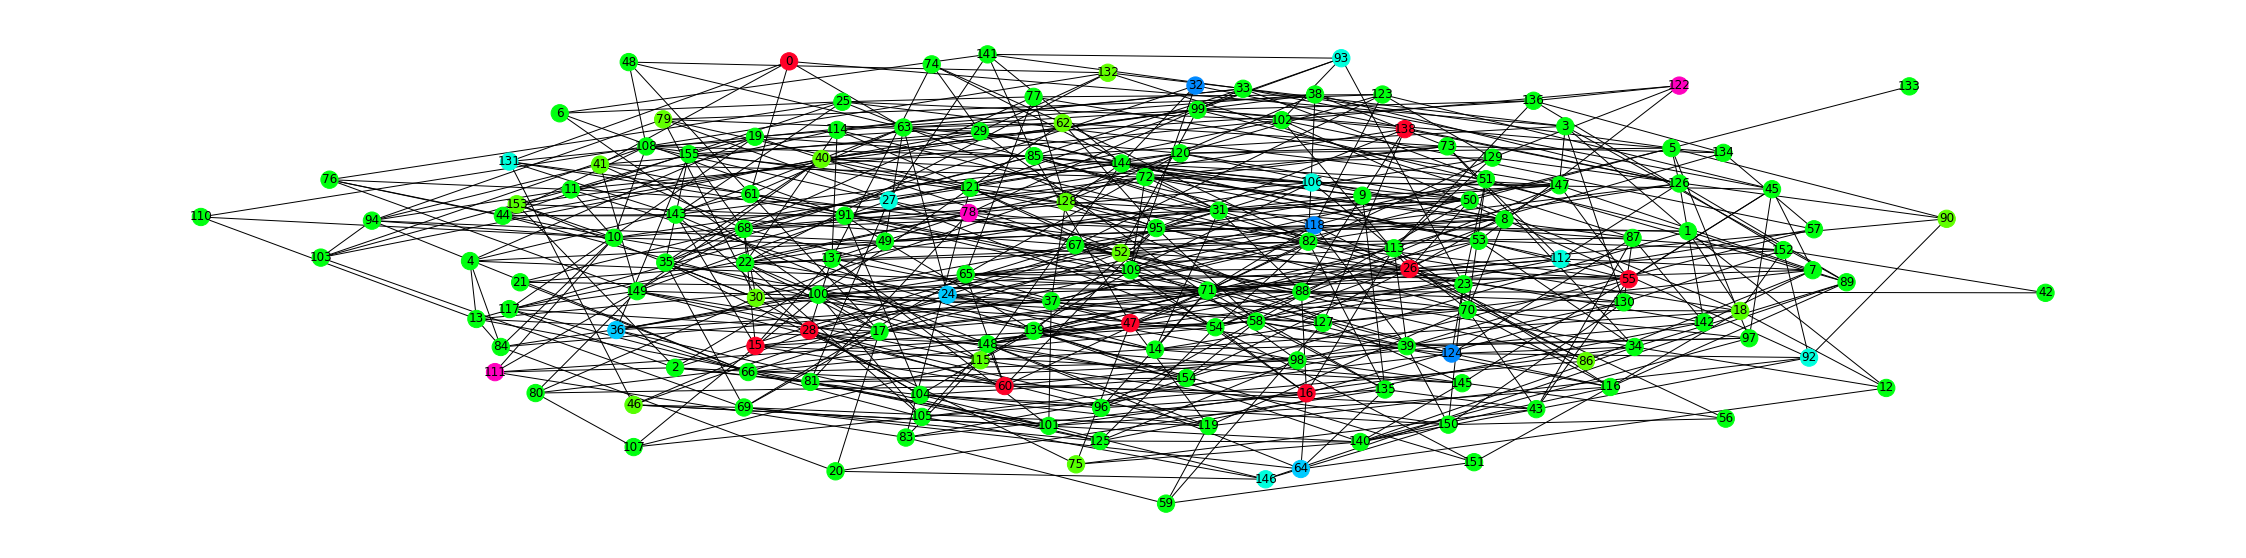

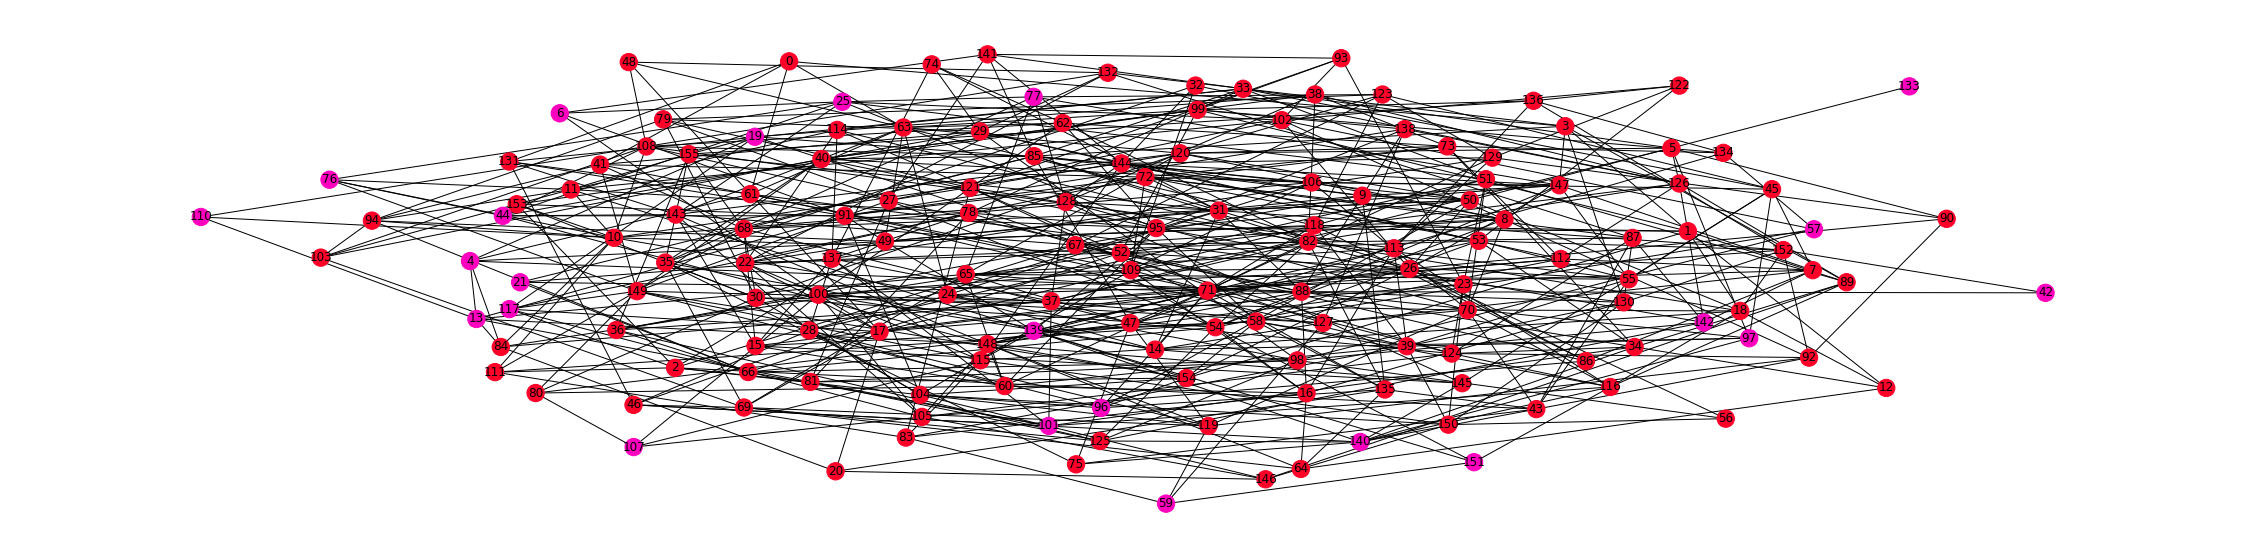

In [5]:
dataset = WDDataset(k_max=7, rho=np.array([0.80, 0.05, 0.03, 0.03, 0.03, 0.03, 0.02, 0.01]), avg_num_nodes=150, avg_degree=4, num_graphs=1000)

graph = dataset.get(0)
print((graph.y==0).sum(), (graph.y==1).sum())
visualize_graph(graph)

## Perfect model

In [6]:
class Perfect_Model():
    
	def __init__(self, k_max) -> None:
		self.k_max = k_max
		self.shifted = torch.zeros((k_max+1, k_max+1))
		self.shifted[:,:-1] = torch.eye(k_max+1)[:,1:]

	def __call__(self, graph, valid = True):
		adj = to_dense_adj(graph.edge_index)[0]
		features = graph.x
		sh_features = torch.mm(features, self.shifted)
		for i in range(self.k_max+1):
			features = features + torch.mm(adj, sh_features)
		return (torch.sum(features[:,1:], dim=1)>0).long()

	def eval(self):
		pass

	def train(self):
		pass

In [7]:
perfect_model = Perfect_Model(k_max=7)

## Validation Tools

In [8]:
train_split = 800
valid_split = 900
test_split  = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def validate_model(model):
	model.eval()
	pred = []
	for i in range(train_split, valid_split):
		graph = dataset.get(i).to(device)
		pred.append(model(graph, valid = True)==graph.y)
	pred = torch.cat(pred, dim=0).float()
	
	perc = pred.mean().item()*100

	mess = f"{perc:.2f}%"
	return perc, mess

def test_model(model):
	model.eval()
	pred = []
	for i in range(valid_split, test_split):
		graph = dataset.get(i).to(device)
		pred.append(model(graph, valid = True)==graph.y)
	pred = torch.cat(pred, dim=0).float()
	
	perc = pred.mean().item()*100

	print(f"Test accuracy: {perc:.2f}%")
	return perc

def evaluate_model(model):
	val_acc = validate_model(model)
	test_acc = test_model(model)

	return val_acc, test_acc

## Training tools

In [10]:
def create_mini_batch(graph_list):
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)

    nodes_count = graph_list[0].num_nodes

    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):
        # concat the features
        batch_x = torch.cat((batch_x, graph.x))
        # concat the labels
        batch_y = torch.cat((batch_y, graph.y))

        # concat the adjacency matrix as a block diagonal matrix

        # here we have to modify the current graph edge index by adding 
        # to the row and column the number of nodes we have already 
        # added to the batch, this way when computing the sparse block matrix,
        # we position the nodes correctly 
        batch_edge_index = torch.cat((
            batch_edge_index, 
            torch.add(graph.edge_index, nodes_count))
        , dim=1)
        nodes_count += graph.num_nodes

        # create the array of indexes mapping nodes in the batch-graph
        # to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)

        # here we append a vector of [idx+1, idx+1,...] which has dimension graph.num_nodes
        # to our existing batch_batch vector to keep track of the nodes
        batch_batch = torch.cat((
            batch_batch, 
            torch.full((graph.num_nodes,), idx + 1)
        ))

    #create the big sparse graph 
    batch_graph = Data(x=batch_x, edge_index=batch_edge_index, y=batch_y, batch=batch_batch)
    #attach the index array to the Graph structure
    return batch_graph

In [11]:
def train(model, epochs, batch_size, lr, weight_decay=0, print_interval=10, valid_interval=10):

	optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
	criterion = torch.nn.CrossEntropyLoss()

	best_model = None
	best_val_acc = 0

	total_losses = []
	val_accuracies = []

	for epoch in range(epochs):
		model.train()
		losses = []
		perm = torch.randperm(train_split)
		for i in range(0, train_split, batch_size):
			optimizer.zero_grad()
			graph_list = [dataset.get(perm[i+j]) for j in range(batch_size)]
			batch = create_mini_batch(graph_list).to(device)
			pred = model(batch)
			loss = criterion(pred, batch.y)
			loss.backward()
			optimizer.step()
			losses.append(loss.item())
		
		total_losses.append(np.mean(losses))

		if (epoch+1)%valid_interval==0:
			val_acc, mess = validate_model(model)
			val_accuracies.append(val_acc)
			if val_acc > best_val_acc:
				best_val_acc = val_acc
				best_model = copy.deepcopy(model)

		if (epoch+1)%print_interval==0:
			message = "Epoch "+str(epoch+1)+'/'+str(epochs)+' - loss: '+str(np.mean(losses))
			message += " - val_acc: " + str(mess)
			print(message)

	plt.plot(losses, label="Training loss")
	plt.show()

	plt.plot(list(range(0, epochs, valid_interval)), val_accuracies, label="Validation accuracy")
	plt.show()

	evaluate_model(best_model)
	return best_model

## Test different GNN architectures

### GCN

In [12]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GCN

class GCNModel(nn.Module):
	def __init__(self) -> None:
		super().__init__()

		self.convs = nn.ModuleList()

		self.convs.append(GCNConv(8, 10))
		self.convs.append(GCNConv(10, 10))
		self.convs.append(GCNConv(10, 2))


		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim=1)
		self.relu = nn.ReLU()

	def forward(self, graph, valid = False):
		
		x = graph.x
		
		for layer in self.convs[:-1]:
			x = self.relu(layer(x, graph.edge_index))
		
		x = self.convs[-1](x, graph.edge_index)
		x = self.softmax(x)

		if valid:
			x = torch.argmax(x, dim=1)
		return x

Epoch 10/100 - loss: 0.44148862183094023 - val_acc: 87.70%
Epoch 20/100 - loss: 0.3860907506942749 - val_acc: 94.32%
Epoch 30/100 - loss: 0.3503126817941666 - val_acc: 97.42%
Epoch 40/100 - loss: 0.33839105784893037 - val_acc: 98.15%
Epoch 50/100 - loss: 0.33355798542499543 - val_acc: 98.25%
Epoch 60/100 - loss: 0.331264328956604 - val_acc: 98.45%
Epoch 70/100 - loss: 0.33018955171108244 - val_acc: 98.50%
Epoch 80/100 - loss: 0.3293993258476257 - val_acc: 98.48%
Epoch 90/100 - loss: 0.3288392800092697 - val_acc: 98.49%
Epoch 100/100 - loss: 0.3285087579488754 - val_acc: 98.49%


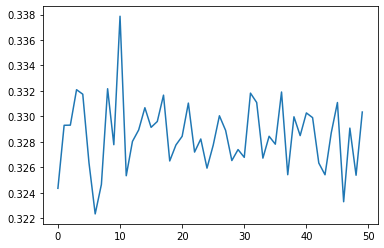

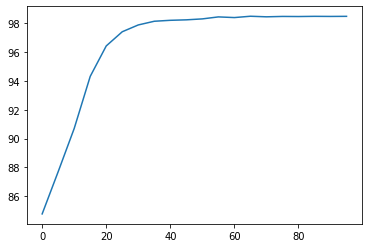

Test accuracy: 98.24%


GCNModel(
  (convs): ModuleList(
    (0): GCNConv(8, 10)
    (1): GCNConv(10, 10)
    (2): GCNConv(10, 2)
  )
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

In [13]:
gcn_model = GCNModel().to(device)
train(gcn_model, epochs=100, batch_size=16, lr=0.01, print_interval=10, valid_interval=5)

### DBGNN

In [23]:
class DBGCNModel(nn.Module):
    
	def __init__(self) -> None:
		super().__init__()

		self.hidden_dim = 16

		self.convs = nn.ModuleList()
		self.convs.append(GCNConv(8, self.hidden_dim))
		self.convs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.convs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.convs.append(GCNConv(self.hidden_dim, 1))
		
		self.thrs = nn.ModuleList()
		self.thrs.append(GCNConv(8, self.hidden_dim))
		self.thrs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.thrs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.thrs.append(GCNConv(self.hidden_dim, 1))

		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim=1)
		self.relu = nn.ReLU()

		self.k = 30


	def forward(self, graph, valid = False):
		
		# Calculate the probability of each node being a tap
		p = graph.x
		for layer in self.convs[:-1]:
			p = self.relu(layer(p, graph.edge_index))
		t = self.thrs[-1](p, graph.edge_index)
		p = self.convs[-1](p, graph.edge_index)

		p = self.sigmoid(p)
		t = self.sigmoid(t)
		
		# Calculate the thresholded probability
		x = 1 / (1 + torch.exp(-self.k * (p - t)))

		# Calculate the final output
		x = torch.stack([1-x, x], dim=1).squeeze()
		if valid:
			x = torch.argmax(x, dim=1)
		return x

Epoch 10/100 - loss: 0.5629761672019958 - val_acc: 74.96%
Epoch 20/100 - loss: 0.5630654299259186 - val_acc: 74.96%
Epoch 30/100 - loss: 0.5630746138095856 - val_acc: 74.96%
Epoch 40/100 - loss: 0.5630407679080963 - val_acc: 74.96%
Epoch 50/100 - loss: 0.5631135702133179 - val_acc: 74.96%
Epoch 60/100 - loss: 0.5630545210838318 - val_acc: 74.96%
Epoch 70/100 - loss: 0.5630438959598542 - val_acc: 74.96%
Epoch 80/100 - loss: 0.5631044518947601 - val_acc: 74.96%
Epoch 90/100 - loss: 0.5629587161540985 - val_acc: 74.96%
Epoch 100/100 - loss: 0.5628309381008149 - val_acc: 74.96%


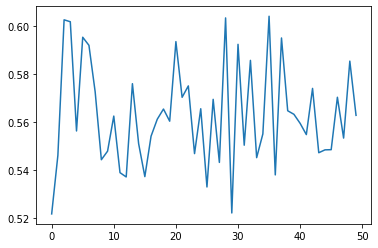

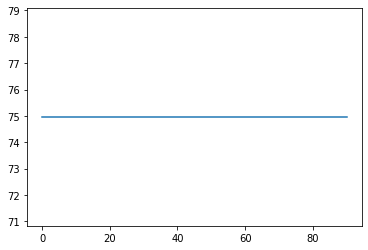

Test accuracy: 75.01%


DBGCNModel(
  (convs): ModuleList(
    (0): GCNConv(8, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
    (3): GCNConv(16, 1)
  )
  (thrs): ModuleList(
    (0): GCNConv(8, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
    (3): GCNConv(16, 1)
  )
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

In [24]:
dbgcn_model = DBGCNModel().cuda()
train(dbgcn_model, epochs=100, batch_size=16, lr=0.01, print_interval=10, valid_interval=10)

## Generate dataset

In [29]:
a = [graph.edge_index.cpu().numpy().reshape(-1) for graph in dataset.data]

In [30]:
np.save('datasets/wddataset/k7_g1000/edge_index.npy', np.array(a, dtype=object), allow_pickle=True)

In [32]:
dv2 = WDDataset(load_path='datasets/wddataset/k7_g1000/', k_max=7)

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: cannot reshape array of size 1352 into shape (15)